# Facial Emotion Recognition (Model Training)

This dataset consists of 48*48 pixel grayscale face images.
The images are centered and occupy an equal amount of space.
The dataset consists of 7 categories:

0. angry
1. disgust (removed)
2. fear
3. happy
4. sad
5. surprise
6. neutral

Training set: 28,709 samples

Public test set: 3,589 examples

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from PIL import Image
import tensorflow as tf
from IPython.display import Image 

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score


from keras.applications.resnet import ResNet50
from keras.applications.nasnet import NASNetLarge
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras import regularizers
import keras.backend as K

import warnings
warnings.filterwarnings('ignore')

## Explore dataset

In [ ]:
# We need to import the file on google drive (authorization)
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# Count the images in the train file
train = {}
count = 0
for folder in os.listdir('/content/drive/MyDrive/Colab Notebooks/FER_2013_images/train'):
    temp = []
    for files in os.listdir(f"/content/drive/MyDrive/Colab Notebooks/FER_2013_images/train/{folder}"):
        temp.append(files)
    count += len(temp)
    train[folder] = temp
    print(f"{folder} has {len(temp)} images")
print(f"Total images in all folders are {count}")

sad has 5303 images
fear has 4547 images
happy has 5555 images
angry has 4443 images
surprise has 3580 images
neutral has 5304 images
Total images in all folders are 28732


In [ ]:
# Count the images in the test file
test = {}
count = 0
for folder in os.listdir('/content/drive/MyDrive/Colab Notebooks/FER_2013_images/test'):
    temp = []
    for files in os.listdir(f"/content/drive/MyDrive/Colab Notebooks/FER_2013_images/test/{folder}"):
        temp.append(files)
    count += len(temp)
    test[folder] = temp
    print(f"{folder} has {len(temp)} images")
print(f"Total images in all folders are {count}")

happy has 1774 images
sad has 1247 images
neutral has 1233 images
surprise has 831 images
angry has 966 images
fear has 1024 images
Total images in all folders are 7075


In [ ]:
# training dataframe with folder name as index
train_df = pd.DataFrame.from_dict(train.values())
train_df.index = train.keys()
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5515,5516,5517,5518,5519,5520,5521,5522,5523,5524,5525,5526,5527,5528,5529,5530,5531,5532,5533,5534,5535,5536,5537,5538,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548,5549,5550,5551,5552,5553,5554
sad,Training_87071220.jpg,Training_85242954.jpg,Training_72597782.jpg,Training_96627207.jpg,Training_86979529.jpg,Training_84536727.jpg,Training_95933622.jpg,Training_70296904.jpg,Training_71527594.jpg,Training_79051384.jpg,Training_98304604.jpg,Training_88613511.jpg,Training_93283768.jpg,Training_96319223.jpg,Training_83061982.jpg,Training_81116022.jpg,Training_9379141.jpg,Training_81097657.jpg,Training_75874059.jpg,Training_70934098.jpg,Training_85343436.jpg,Training_9878242.jpg,Training_69814836.jpg,Training_90212526.jpg,Training_88381807.jpg,Training_71318950.jpg,Training_81237423.jpg,Training_85286134.jpg,Training_86674826.jpg,Training_90858925.jpg,Training_80579424.jpg,Training_98001177.jpg,Training_94586991.jpg,Training_84431642.jpg,Training_97688399.jpg,Training_72581485.jpg,Training_70114086.jpg,Training_80331424.jpg,Training_9816139.jpg,Training_74101198.jpg,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
fear,Training_28883417.jpg,Training_76739904.jpg,Training_29532565.jpg,Training_80686318.jpg,Training_69251402.jpg,Training_86616037.jpg,Training_94236917.jpg,Training_93838431.jpg,Training_93879243.jpg,Training_40559287.jpg,Training_9050942.jpg,Training_90390677.jpg,Training_92472970.jpg,Training_76025078.jpg,Training_92021165.jpg,Training_96251939.jpg,Training_89096197.jpg,Training_33315056.jpg,Training_73859563.jpg,Training_77332721.jpg,Training_91005353.jpg,Training_84664773.jpg,Training_40608044.jpg,Training_28699638.jpg,Training_93467382.jpg,Training_93535574.jpg,Training_91996560.jpg,Training_31868274.jpg,Training_29430539.jpg,Training_95098955.jpg,Training_41361960.jpg,Training_35529596.jpg,Training_41842862.jpg,Training_55504730.jpg,Training_29327810.jpg,Training_41627781.jpg,Training_98886525.jpg,Training_39659332.jpg,Training_6919979.jpg,Training_8477832.jpg,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
happy,Training_93476116.jpg,Training_94183204.jpg,Training_89945972.jpg,Training_94994029.jpg,Training_93804310.jpg,Training_90815186.jpg,Training_98696295.jpg,Training_95334634.jpg,Training_87372892.jpg,Training_87277043.jpg,Training_9712182.jpg,Training_96542538.jpg,Training_93025766.jpg,Training_93725542.jpg,Training_91916018.jpg,Training_9011924.jpg,Training_90084698.jpg,Training_94563969.jpg,Training_96046781.jpg,Training_88641930.jpg,Training_98302699.jpg,Training_86923341.jpg,Training_87896540.jpg,Training_92857559.jpg,Training_86109453.jpg,Training_93085194.jpg,Training_99523432.jpg,Training_87314996.jpg,Training_96395405.jpg,Training_89114155.jpg,Training_95364050.jpg,Training_91516775.jpg,Training_90259368.jpg,Training_87546879.jpg,Training_88187627.jpg,Training_8648722.jpg,Training_96435627.jpg,Training_85749374.jpg,Training_91322946.jpg,Training_92534494.jpg,...,Training_20664857.jpg,Training_15867599.jpg,Training_11168767.jpg,Training_2259595.jpg,Training_10220224.jpg,Training_16048380.jpg,Training_14426728.jpg,Training_25499885.jpg,Training_23280217.jpg,Training_24304378.jpg,Training_15192022.jpg,Training_19262199.jpg,Training_13983518.jpg,Training_16565357.jpg,Training_23949441.jpg,Training_18252673.jpg,Training_1577302.jpg,Training_22315819.jpg,Training_23912109.jpg,Training_10917734.jpg,Training_19387154.jpg,Training_21630194.jpg,Training_18103763.jpg,Training_15984272.jpg,Training_22418682.jpg,Training_25091944.jpg,Training_19453181.jpg,Training_1564486.jpg,Training_11939

In [ ]:
# list of all the emotions to classify in the output
emotions = [k for k in train.keys()]
emotions

['sad', 'fear', 'happy', 'angry', 'surprise', 'neutral']

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/FER_2013_images/'

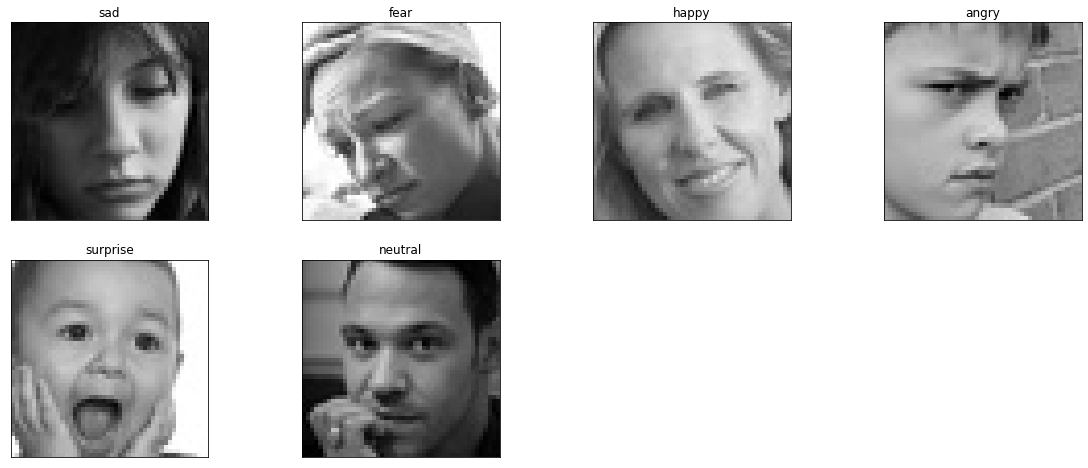

In [ ]:
# lets see one image from each category from training data
plt.figure(figsize = (20, 8))
for i in range(6):
    ax = plt.subplot(2,4, i+1)
    img = cv2.imread(f"{base_dir}train/{emotions[i]}/{train_df.loc[emotions[i], i+7]}")
    ax.imshow(img, cmap = 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotions[i])

In [ ]:
# To know the shape of image
one_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/FER_2013_images/train/surprise/Training_10013223.jpg')
one_img.shape

(48, 48, 3)

## Data Preprocessing

Using Keras "ImageDataGenerator" to augment images in real-time while our model is still training.

The ImageDataGenerator class has 3 methods `flow()`, `flow_from_directory()`, and `flow_from_dataframe()` to read the images from a big numpy array and folders containing images.

Here, we use flow_from_directory() because it expects at least one directory under the given directory path.




In [ ]:
# Data preprocessing(augmentation)
train_dir = f"{base_dir}/train"
test_dir = f"{base_dir}/test"

train_datagen = ImageDataGenerator(horizontal_flip = True,
                  rotation_range= 10,
                  zoom_range = 0.1, 
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  rescale = 1./255,
                  fill_mode = 'nearest',
                  validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale=1./255,
                  validation_split=0.2)

test_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow_from_directory(
                        train_dir,
                        target_size=(48,48),
                        batch_size=64,
                        class_mode='categorical',
                        color_mode='grayscale',
                        subset = "training")

valid_generator = valid_datagen.flow_from_directory(train_dir,
                           target_size=(48,48),
                           class_mode='categorical',
                           subset='validation',
                           color_mode='grayscale',
                           batch_size=64)

test_generator = test_datagen.flow_from_directory(
                        test_dir,
                        target_size=(48,48),
                        batch_size=64,
                        color_mode='grayscale',
                        class_mode='categorical')

Found 22988 images belonging to 6 classes.
Found 5744 images belonging to 6 classes.
Found 7075 images belonging to 6 classes.


### CNN Model Building

In [ ]:
model = None

# Build model on the top of base model (transfer learning)
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(6, activation='softmax'))


# model Summary
print(f'Number of layers:', len(model.layers))
model.summary()

Number of layers: 14
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None,

In [ ]:
# function to calculate f1_score
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# evaluation metrics
from keras.metrics import AUC, BinaryAccuracy, Precision, Recall
metric = [BinaryAccuracy(name = 'accuracy'), 
      Precision(name = 'precision'), 
      Recall(name = 'recall'), 
      AUC(name = 'AUC'),]

In [ ]:
# callbacks
checkpoint = ModelCheckpoint('model.h5')

earlystop = EarlyStopping(patience=20, verbose=1)
# restore_best_weights=True)
                      
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                factor=0.5, 
                patience=20, 
                verbose=1,
                min_lr=1e-10)
# min_delta=0.0001)
callbacks = [checkpoint,earlystop,reduce_lr]

In [ ]:
# compile model (optimization)
model.compile(optimizer= 'Adam', loss='categorical_crossentropy', metrics=metric)

The difference between `Keras.fit` and `Keras.fit_generator` functions used to train a deep learning neural network:

`model.fit` is used when the entire training dataset can fit into the memory 

*   `model.fit` is used when the entire training dataset can fit into the memory and no data augmentation is applied.
*   `model.fit_generator` is used when either we have a huge dataset to fit into our memory or when data augmentation needs to be applied.




In [ ]:
# model fitting
history = model.fit_generator(train_generator, validation_data=valid_generator,epochs=100,verbose = 1,callbacks=callbacks)

Epoch 1/100
360/360 [==============================] - 13722s 38s/step - loss: 12.0252 - accuracy: 0.7888 - precision: 0.1973 - recall: 0.0861 - AUC: 0.5304 - val_loss: 37.1911 - val_accuracy: 0.7176 - val_precision: 0.1526 - val_recall: 0.1525 - val_AUC: 0.4907
Epoch 2/100
360/360 [==============================] - 42s 117ms/step - loss: 2.3726 - accuracy: 0.8331 - precision: 0.2533 - recall: 7.6426e-04 - AUC: 0.5580 - val_loss: 4.0007 - val_accuracy: 0.7788 - val_precision: 0.2055 - val_recall: 0.1140 - val_AUC: 0.5325
Epoch 3/100
360/360 [==============================] - 42s 117ms/step - loss: 1.9258 - accuracy: 0.8332 - precision: 0.3981 - recall: 0.0016 - AUC: 0.5583 - val_loss: 2.2842 - val_accuracy: 0.8161 - val_precision: 0.2510 - val_recall: 0.0522 - val_AUC: 0.5530
Epoch 4/100
360/360 [==============================] - 42s 117ms/step - loss: 1.8206 - accuracy: 0.8332 - precision: 0.3598 - recall: 0.0017 - AUC: 0.5649 - val_loss: 1.8265 - val_accuracy: 0.8327 - val_precision:

### Save Model

In [ ]:
model.save('model_optimal_singlechannel_addingdata_0626.h5')
model.save_weights('model_weights_singlechannel_addingdata_0626.h5')

### Plotting

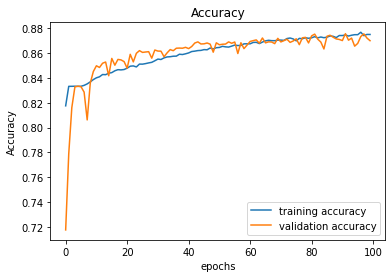

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label= 'training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

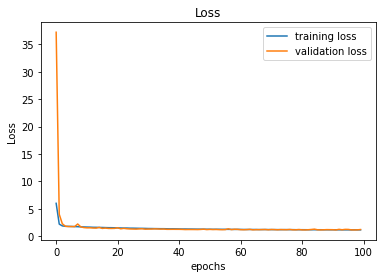

In [ ]:
plt.figure(0)
plt.plot(history.history['loss'], label= 'training loss')
plt.plot(history.history['val_loss'], label= 'validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

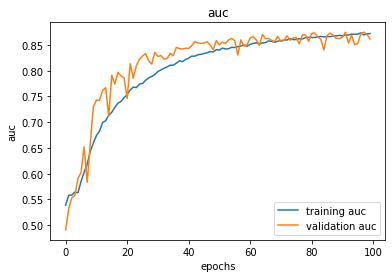

In [ ]:
plt.figure(0)
plt.plot(history.history['AUC'], label= 'training auc')
plt.plot(history.history['val_AUC'], label= 'validation auc')
plt.title('auc')
plt.xlabel('epochs')
plt.ylabel('auc')
plt.legend()

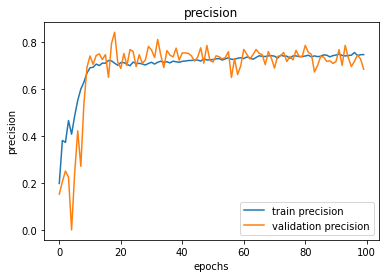

In [ ]:
plt.figure(0)
plt.plot(history.history['precision'], label= 'train precision')
plt.plot(history.history['val_precision'], label= 'validation precision')
plt.title('precision')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

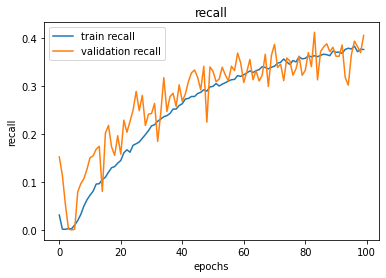

In [ ]:
plt.figure(0)
plt.plot(history.history['recall'], label= 'train recall')
plt.plot(history.history['val_recall'], label= 'validation recall')
plt.title('recall')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()

### Testing Dataset Accuracy

In [ ]:
model.evaluate(test_generator)

111/111 [==============================] - 3320s 30s/step - loss: 1.1982 - accuracy: 0.8726 - precision: 0.6933 - recall: 0.4225 - AUC: 0.8685


[1.1982351541519165,
 0.8726028800010681,
 0.6933426260948181,
 0.4224734902381897,
 0.8685198426246643]

### Confusion Matrix

Confusion Matrix
[[ 228  450  729  992  656  500]
 [ 261  445  757 1032  635  508]
 [ 268  567  963 1280  762  604]
 [ 295  564  898 1186  769  532]
 [ 303  539  863 1151  819  568]
 [ 210  360  646  814  471  363]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.06      0.09      3555
        fear       0.15      0.12      0.14      3638
       happy       0.20      0.22      0.21      4444
     neutral       0.18      0.28      0.22      4244
         sad       0.20      0.19      0.20      4243
    surprise       0.12      0.13      0.12      2864

    accuracy                           0.17     22988
   macro avg       0.17      0.17      0.16     22988
weighted avg       0.17      0.17      0.17     22988



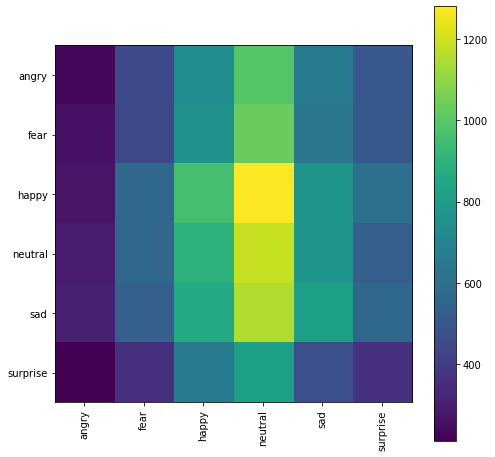

In [ ]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
# Import the model (if re-connect)
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Kevin/model_optimal.h5')